In [15]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.neighbors import NearestNeighbors
import random
np.random.seed(1)
mu1 = [0, 0]
mu2 = [-20, 1]
sigma1 = [[5, 3], [3, 5]]  # must be positive semi-definite
sigma2 = [[6,-2],[-2,6]]
n = 5000
m = 100
x1 = np.random.multivariate_normal(mu1, sigma1, size=n).T
x2 = np.random.multivariate_normal(mu2, sigma2, size=m).T
x = np.hstack([x1, x2])

In [16]:
print(x.shape)

(2, 5100)


Text(0.5,1,'Raw Data')

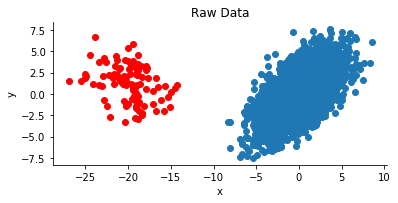

In [17]:
fig, ax = plt.subplots()
ax.scatter(x1[0], x1[1])
ax.scatter(x2[0], x2[1], c="red")
ax.set_aspect("equal")
#ax.set_xlim(-8, 8)
#ax.set_ylim(-8, 8)
ax.set_xlabel("x")
ax.set_ylabel("y")
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)
ax.set_title("Raw Data")

In [24]:
def SMOTE(minority_data, total_data, k, a, num_samples):
    minority_data = minority_data.T
    total_data = total_data.T
    knn = NearestNeighbors(n_neighbors=k+1)
    knn.fit(total_data)
    synth = []
    #print(minority_data)
    #print(total_data)
    
    for _ in range(num_samples):
        i = np.random.choice(minority_data.shape[0])
        query = [minority_data[i]]
        neighbors = knn.kneighbors(query, return_distance=False)
        neighbors = total_data[neighbors]
        j = np.random.choice(k)+1
        l = total_data[j]
        s = a*query + (1-a)*l
        synth.append(s)

    synth = np.vstack(synth)
    return synth
    

In [28]:
xs = SMOTE(x2, x2, 5, 0.5, 1000)
xs = xs.T

TypeError: can't multiply sequence by non-int of type 'float'

Text(0.5,1,'Raw Data')

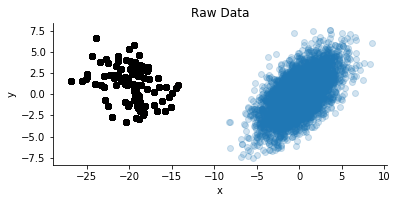

In [26]:
fig, ax = plt.subplots()
ax.scatter(x1[0], x1[1], alpha=0.2)
ax.scatter(x2[0], x2[1], c="red")
ax.scatter(xs[0], xs[1], c="black")
ax.set_aspect("equal")
#ax.set_xlim(-8, 8)
#ax.set_ylim(-8, 8)
ax.set_xlabel("x")
ax.set_ylabel("y")
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)
ax.set_title("Raw Data")